# Principal Component Regression on Diamond Quality
Author: Kenneth Leung

### Import data and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data/diamonds.csv', sep=',', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Data Preparation

In [3]:
target = 'price'
X = df.drop(target,axis=1)
y = df[target]

In [4]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


#### Encoding categorical variables

In [5]:
X['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [6]:
# Reference: https://www.diamondrocks.co.uk/magazine/ideal-cut-diamonds/
cut_mapping = {'Fair': 1, 
               'Good': 2, 
               'Very Good': 3, 
               'Premium': 4, 
               'Ideal': 5, 
              }

X['cut'] = X['cut'].map(cut_mapping) 

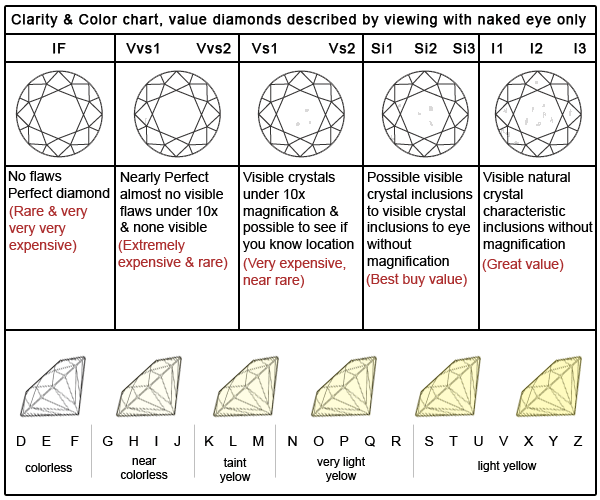

In [7]:
X['color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [8]:
# Reference: https://beyond4cs.com/color/choosing-a-diamond-color/
color_mapping = {'J': 1, 
                 'I': 2, 
                 'H': 3, 
                 'G': 4, 
                 'F': 5, 
                 'E': 6, 
                 'D': 7, 
                }

X['color'] = X['color'].map(color_mapping) 

In [9]:
X['clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [10]:
# Reference: https://www.pinterest.com/pin/299982025151450686/
clarity_mapping = {'I1': 1, 
                   'I2': 2,
                   'I3': 3,
                   'SI3': 4,
                   'SI2': 5, 
                   'SI1': 6, 
                   'VS2': 7, 
                   'VS1': 8, 
                   'VVS2': 9, 
                   'VVS1': 10,  
                   'IF': 11, 
                  }

X['clarity'] = X['clarity'].map(clarity_mapping) 

In [11]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,5,6,5,61.5,55.0,3.95,3.98,2.43
2,0.21,4,6,6,59.8,61.0,3.89,3.84,2.31
3,0.23,2,6,8,56.9,65.0,4.05,4.07,2.31
4,0.29,4,2,7,62.4,58.0,4.20,4.23,2.63
5,0.31,2,1,5,63.3,58.0,4.34,4.35,2.75


#### Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(43152, 9)

In [14]:
# Run standardization on X variables
X_train_scaled, X_test_scaled = scale(X_train), scale(X_test)
X_train_scaled

array([[ 2.56005606, -1.70896512,  0.3479487 , ...,  2.22945022,
         2.13820916,  1.73820671],
       [ 0.44739205, -0.81219173,  0.93662126, ...,  0.74754991,
         0.65671016,  0.5377332 ],
       [ 0.63753181,  0.08458166, -0.82939642, ...,  0.76540413,
         0.70028366,  0.79195112],
       ...,
       [-0.98921948, -0.81219173,  0.3479487 , ..., -1.10928903,
        -1.11237394, -1.18529936],
       [ 0.21499901,  0.08458166, -2.00674153, ...,  0.35475706,
         0.25583396,  0.39650102],
       [ 0.72203837,  0.08458166,  0.3479487 , ...,  0.97072767,
         0.91815116,  0.80607434]])

___
## Default Linear Regression Methods

In [15]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

### (1) Linear Regression (no regularization)

#### Train set cross-validation

In [16]:
lin_reg = LinearRegression().fit(X_train_scaled, y_train)

In [17]:
lr_scores = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, 
                                 cv=cv, scoring='neg_root_mean_squared_error')
lr_scores

array([1153.34029914, 1164.63180508, 1183.09592238, 1125.96477372,
       1192.06676333, 1312.58957426, 1187.64719753, 1163.05489451,
       1184.47397232, 1189.3878714 ])

In [18]:
lr_score_train = np.mean(lr_scores)
lr_score_train

1185.625307367658

#### Predict

In [19]:
y_predicted = lin_reg.predict(X_test_scaled)
lr_score_test = mean_squared_error(y_test, y_predicted, squared=False)
lr_score_test

1194.251234624873

___
## (2) Lasso Regression (L1 regularization)

#### Train set cross-validation

In [20]:
lasso_reg = LassoCV().fit(X_train_scaled, y_train)

In [21]:
lasso_scores = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, 
                              cv=cv, scoring='neg_root_mean_squared_error')
lasso_scores

array([1151.7936031 , 1167.40203082, 1184.52098758, 1129.35378051,
       1193.78443795, 1306.0786174 , 1189.56676768, 1166.34532066,
       1182.29448425, 1186.91992527])

In [22]:
lasso_score_train = np.mean(lasso_scores)
lasso_score_train

1185.8059955212439

#### Predict

In [23]:
y_predicted = lasso_reg.predict(X_test_scaled)
lasso_score_test = mean_squared_error(y_test, y_predicted, squared=False)
lasso_score_test

1194.5969388472497

___
### (3) Ridge Regression (L2 regularization)

#### Train set cross-validation

In [24]:
ridge_reg = RidgeCV().fit(X_train_scaled, y_train)

In [25]:
ridge_scores = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, 
                                    cv=cv, scoring='neg_root_mean_squared_error')
ridge_scores

array([1152.95587476, 1165.10525955, 1183.29871037, 1126.91248815,
       1192.36156531, 1311.0632325 , 1187.97351697, 1163.62549171,
       1183.91574854, 1188.7446022 ])

In [26]:
ridge_score_train = np.mean(ridge_scores)
ridge_score_train

1185.5956490056071

#### Predict

In [27]:
y_predicted = ridge_reg.predict(X_test_scaled)
ridge_score_test = mean_squared_error(y_test, y_predicted, squared=False)
ridge_score_test

1194.2370072495762

___
### Principal Components Regression

#### Evaluate for different number of principal components

In [28]:
lin_reg = LinearRegression()
rmse_list = []

In [29]:
# First generate all the principal components
pca = PCA()
X_train_pc = pca.fit_transform(X_train_scaled)
X_train_pc.shape

(43152, 9)

In [30]:
pca.explained_variance_ratio_

array([0.46847289, 0.1566755 , 0.13616805, 0.10887811, 0.07727933,
       0.03974211, 0.00579353, 0.00535276, 0.00163772])

In [31]:
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, X_train_pc[:,:i], # Use first i principal components
                                      y_train, cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

In [32]:
rmse_list

[2098.392487302574,
 1987.1799238641136,
 1930.840486077163,
 1928.5656822113117,
 1517.9617503411193,
 1516.5241825746045,
 1366.5238995372824,
 1279.2862479847195,
 1185.6253073676558]

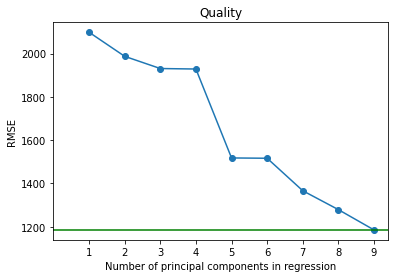

In [33]:
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
# plt.ylim(ymin=0.7, ymax=0.86);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

In [41]:
# Visually determine optimal number of principal components
best_pc_num = 7

In [42]:
pcr_score_train = -1 * cross_val_score(lin_reg, X_train_pc[:,:best_pc_num], y_train, 
                                 cv=cv, scoring='neg_root_mean_squared_error').mean()
pcr_score_train

1366.5238995372824

#### Predict

In [43]:
# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

In [44]:
# Get principal components of test set
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]
X_test_pc.shape

(10788, 7)

In [45]:
# Prediction with test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)
pcr_score_test

1268.5959991649063

___
### Evaluation

In [46]:
train_metrics = np.array([round(lr_score_train,3), round(lasso_score_train,3), round(ridge_score_train,3), round(pcr_score_train,3)]) 
train_metrics = pd.DataFrame(train_metrics, columns=['RMSE (Train Set)'])
train_metrics.index = ['Linear Regression', 'Lasso Regression', 
                 'Ridge Regression', f'PCR ({best_pc_num} components)']
train_metrics

,RMSE (Train Set)
Linear Regression,1185.625
Lasso Regression,1185.806
Ridge Regression,1185.596
PCR (7 components),1366.524


In [47]:
test_metrics = np.array([round(lr_score_test,3), round(lasso_score_test,3), round(ridge_score_test,3), round(pcr_score_test,3)]) 
test_metrics = pd.DataFrame(test_metrics, columns=['RMSE (Test Set)'])
test_metrics.index = ['Linear Regression', 'Lasso Regression', 
                      'Ridge Regression', f'PCR ({best_pc_num} components)']
test_metrics

,RMSE (Test Set)
Linear Regression,1194.251
Lasso Regression,1194.597
Ridge Regression,1194.237
PCR (7 components),1268.596


___
#### References

- https://github.com/JWarmenhoven/ISLR-python/blob/9463d8c784b5cc9a271375e901524d4f1cf7378d/Notebooks/Chapter%206.ipynb
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://en.wikipedia.org/wiki/Principal_component_regression